In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from google.colab import files

# from google.colab import drive
# drive.mount('/content/drive/')

### Load data

In [3]:
def load_dataset(id):
    # folder = '/content/drive/My Drive/_MCGILL/cosmicdawn' # nin
#     folder = '/content/drive/My Drive/phys489' # mbj
    folder = './data'
    data = np.load(f"{folder}/dataset{id}.npy")
    labels = np.load(f"{folder}/labels{id}.npy")
    mask = np.load(f"{folder}/mask{id}.npy")
    # print(data.shape, labels.shape)
    return data, labels, mask

In [4]:
# print(data)

In [5]:
data, labels, mask = load_dataset(20)

### Convert to proper dataset shape (if necessary)

In [ ]:
# real = data.real[:,:]
# print(real.shape)
# imag = data.imag[:,:,:]
# data_new = np.zeros((data.shape[0], data.shape[1], data.shape[2], 3))
# data_new[:, :, :, 0] = real
# data_new[:, :, :, 1] = imag
# data_new[:, :, :, 2] = mask
# data = data_new

# real = labels.real
# imag = labels.imag
# labels_new = np.zeros((labels.shape[0], labels.shape[1], labels.shape[2], 2))
# labels_new[:, :, :, 0] = real
# labels_new[:, :, :, 1] = imag
# labels = labels_new

# print(data.shape)
# print(labels.shape)

(20, 1500, 818, 3)


ValueError: ignored

### Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
del data

In [7]:
# X_train = X_train[:,:,:,:2]
# X_test = X_test[:,:,:,:2]

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(mask.shape)

(13, 1500, 818, 3) (7, 1500, 818, 3) (13, 1500, 818, 2) (7, 1500, 818, 2)
(1500, 818)


# ML model

In [ ]:
import keras.backend as K
'''
MSE, only over masked areas
'''
def masked_MSE(y_true, y_pred):
  for yt in y_true: # for each example in the batch
    yt = yt[mask == True]
  for yp in y_pred:
    yp = yp[mask == True]
  loss_val = K.mean(K.square(y_pred - y_true))
  return loss_val

In [ ]:
'''
Original deep model
'''
#   model = keras.Sequential([
#       layers.Conv2D(12, kernel_size=3, activation='relu', padding='same', input_shape=(1500,818,3), kernel_initializer=keras.initializers.GlorotNormal()),
#       layers.MaxPooling2D((2,2)),
#       layers.UpSampling2D((2,2)),
#       layers.Conv2D(12, kernel_size=5, activation='relu', padding='same', kernel_initializer=keras.initializers.GlorotNormal()),
#       layers.MaxPooling2D((2,2)),
#       layers.UpSampling2D((2,2)),
#       layers.Conv2D(12, kernel_size=5, activation='relu', padding='same', kernel_initializer=keras.initializers.GlorotNormal()),
#       layers.MaxPooling2D((2,2)),
#       layers.UpSampling2D((2,2)),
#       layers.Conv2D(12, kernel_size=5, activation='relu', padding='same', kernel_initializer=keras.initializers.GlorotNormal()),
#       layers.MaxPooling2D((2,2)),
#       layers.UpSampling2D((2,2)),
#       layers.Dense(12, activation='relu'),
#       layers.Dense(2)
#   ])

In [ ]:
def build_and_compile_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
#         keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(2)
    ])
    
  

  model.compile(loss=masked_MSE, optimizer=tf.keras.optimizers.Adam(0.001), metrics=[masked_MSE])
  return model

In [ ]:
model = None
model = build_and_compile_model()
model.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 1500, 818, 12)     336       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 750, 409, 12)      0         
_________________________________________________________________
up_sampling2d_43 (UpSampling (None, 1500, 818, 12)     0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 1500, 818, 12)     3612      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 750, 409, 12)      0         
_________________________________________________________________
up_sampling2d_44 (UpSampling (None, 1500, 818, 12)     0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 1500, 818, 12)   

In [92]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=1, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 9s 9s/step - loss: 1985.0740 - masked_MSE: 1985.0740 - val_loss: 1848.1903 - val_masked_MSE: 1848.1903
Epoch 2/1000
1/1 [==============================] - 2s 2s/step - loss: 1863.7406 - masked_MSE: 1863.7407 - val_loss: 1771.3414 - val_masked_MSE: 1771.3416
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 1786.7758 - masked_MSE: 1786.7759 - val_loss: 1712.9501 - val_masked_MSE: 1712.9501
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 1727.2965 - masked_MSE: 1727.2965 - val_loss: 1661.5436 - val_masked_MSE: 1661.5436
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 1672.8336 - masked_MSE: 1672.8336 - val_loss: 1610.0675 - val_masked_MSE: 1610.0675
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - loss: 1616.6542 - masked_MSE: 1616.6542 - val_loss: 1559.5836 - val_masked_MSE: 1559.5836
Epoch 7/1000
1/1 [==============================] - 1s 1s/step - loss:

In [ ]:
# del history

In [93]:
model.save('model.h5')

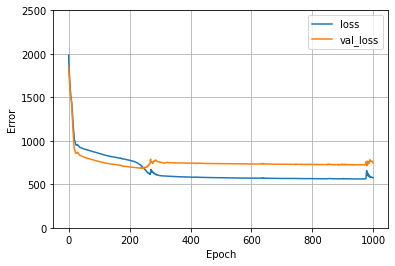

In [94]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2500])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [95]:
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [96]:
while True:pass

KeyboardInterrupt: ignored

## Make predictions

In [ ]:
model.layers[0].get_weights()

In [ ]:
# model = keras.models.load_model('model.h5', custom_objects={'masked_MSE': masked_MSE})

In [97]:
def make_predictions(input):
  preds = model.predict(input)
  # print(preds)
  return preds

def download_predictions(preds, i):
  np.save("pred.npy", preds[i])
  np.save("og.npy", X_train[i])
  np.save("true.npy", y_train[i])
  files.download('pred.npy')
  files.download('og.npy')
  files.download('true.npy')

  # Apply mask to predictions
  # for j, pred in enumerate(preds):
    # pred[mask == False] = X_train[j][mask == False][:,:2] # (1-mask)*og + mask*pred
  
  # np.save("pred_masked.npy", preds[i])
  # files.download('pred_masked.npy')

In [ ]:
# eye = np.dstack([np.zeros((1500, 818))]*2)
# eye = np.dstack([np.eye(1500, 818)]*2)
# print(eye.shape)
# pred = model.predict(np.array([eye,]))
np.save("pred.npy", X_train[6])
files.download('pred.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pred.shape

(1, 1500, 818, 2)

In [98]:
preds = make_predictions(X_train)
# print(X_train[0].shape)
# print(mask.shape)

In [99]:
download_predictions(preds, 6)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

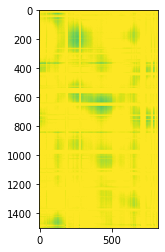

In [ ]:
plt.imshow(preds[0][:,:,0])